# Overview: Estimating mutual information on high dimensional data using MINE
**Motivation**: when testing MINE on my own data, I found that MINE gives different results (both in value and relative value) resulting from different lr and different hidden size of NN. Since there is no discussion on how to select hyperparameters on MINE, this notebook aim to work on following points: 

1. Generate synthetic data with different dim and different MI
2. Run different MINE to compare their results with true MI to test whether the relative relationship holds 
3. On different dim, select lr and hidden state
4. How big is dim so that MINE does not work on calculating relative relationships?
5. Generate synthetic data with different dim and different Entropy. Does MINE works on entropy calculation?

**Take aways**
1. MINE can test the relative relationship of mutual information on 7-dimensional data with selected lr. Both NN with hidden size of 512 and 128 works.
2. MINE cannot test the relative relationship of mutual information on 7-dimensional data with selected lr. Both NN with hidden size of 512 and 128 works.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.mixture import GaussianMixture
import torch
from model.decoder import Decoder
from model.encoder import Encoder
from model.infonet import infonet
from model.query import Query_Gen_transformer
from scipy.stats import rankdata
from scipy.special import digamma
from scipy.stats import gamma

from baseline.KSG import kraskov_mi
from baseline.MINE import MINE_esti

import os
import torch
import matplotlib.pyplot as plt
from torch import optim

import numpy as np
import torch
from tqdm import tqdm
device = "cpu"
import PIL
from PIL import Image
import argparse

# Define your functions/classes (e.g., MineFlattened, train, ma, sample_batch)
# Assume these are already defined as in your script.

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from matplotlib import pyplot as plt

66817


In [2]:
def learn_mine(batch, mine_net, mine_net_optim, ma_et, ma_rate=0.01):
    """
    batch: ((joint_images, joint_vectors), (marg_images, marg_vectors))
    mine_net: instance of MineFlattened
    """
    (joint_images, joint_vectors), (marg_images, marg_vectors) = batch
    
    joint_images_torch = torch.FloatTensor(joint_images).cuda()
    joint_vectors_torch = torch.FloatTensor(joint_vectors).cuda()
    marg_images_torch  = torch.FloatTensor(marg_images).cuda()
    marg_vectors_torch = torch.FloatTensor(marg_vectors).cuda()
    
    t  = mine_net(joint_images_torch, joint_vectors_torch)  # shape: (batch_size, 1)
    et = torch.exp(mine_net(marg_images_torch, marg_vectors_torch))  # shape: (batch_size, 1)
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    ma_et = (1 - ma_rate)*ma_et + ma_rate*torch.mean(et)
    loss = -(torch.mean(t) - (1.0 / ma_et.mean()).detach() * torch.mean(et))
    
    mine_net_optim.zero_grad()
    loss.backward()
    mine_net_optim.step()
    
    return mi_lb, ma_et, loss

def sample_batch(data, batch_size=100, sample_mode='joint'):
    if sample_mode == 'joint':
        indices = np.random.choice(len(data), size=batch_size, replace=False)
        # Collect images and vectors from the same indices
        images = [data[i][0] for i in indices]
        vectors = [torch.tensor(data[i][1], dtype=torch.float32) for i in indices]
    else:
        # 'marginal' -> images from one set of indices, vectors from another
        joint_indices = np.random.choice(len(data), size=batch_size, replace=False)
        marginal_indices = np.random.choice(len(data), size=batch_size, replace=False)
        images = [data[j][0] for j in joint_indices]
        vectors = [torch.tensor(data[m][1], dtype=torch.float32) for m in marginal_indices]
    
    images = torch.stack(images, axis=0)
    vectors = torch.stack(vectors, axis=0)

    # Return as a tuple
    return images, vectors

def train(data, mine_net, mine_net_optim, batch_size=300, iter_num=5000, log_freq=100):
    result = []
    ma_et = 1.0
    losses = []
    
    for i in tqdm(range(iter_num)):
        # Sample joint and marginal batches
        joint_batch = sample_batch(data, batch_size=batch_size, sample_mode='joint')
        marg_batch  = sample_batch(data, batch_size=batch_size, sample_mode='marginal')
        batch = (joint_batch, marg_batch)
        
        mi_lb, ma_et, loss = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.detach().cpu().numpy())
        losses.append(loss.item())
    return result, losses

def ma(a, window_size=100):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]


In [3]:
class Mine512(nn.Module):
    def __init__(self, hidden_size=512, input_size =100):
        super().__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
    
    def forward(self, image, vector):
        batch_size = image.size(0)
        image_flat = image.view(batch_size, -1)
        vector = vector.view(batch_size, -1)
        combined_input = torch.cat([image_flat, vector], dim=1)  
        
        x = F.elu(self.fc1(combined_input))
        x = F.elu(self.fc2(x))
        output = self.fc3(x)  
        return output

In [23]:
class Mine128(nn.Module):
    def __init__(self, hidden_size=100, input_size =100):
        super().__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
    
    def forward(self, image, vector):
        batch_size = image.size(0)
        image_flat = image.view(batch_size, -1)
        vector = vector.view(batch_size, -1)
        combined_input = torch.cat([image_flat, vector], dim=1)  
        
        x = F.elu(self.fc1(combined_input))
        x = F.elu(self.fc2(x))
        output = self.fc3(x)  
        return output

In [5]:
def high_dim_gauss(rou, dim, seq_len):
    block = np.array([[1, rou], [rou, 1]])
    cov_matrix = np.kron(np.eye(dim), block)
    
    mean = np.zeros(2 * dim)
    sample = np.random.multivariate_normal(mean, cov_matrix, seq_len)
    mutual_info = dim * (-0.5 * np.log(1 - rou**2))
    
    return sample, mutual_info

In [49]:
def test_hidden_size(rou, dim):
    sample, mutual_info = high_dim_gauss(rou, dim, lens)
    sample = torch.tensor(sample, dtype=torch.float32)
    sample_data=[]
    for i in sample:
        data=[]
        data.append(i[:dim].to(torch.float32))
        data.append(i[dim:].to(torch.float32))
        sample_data.append(data)
        
    mine_net = Mine512(input_size=2*dim).cuda()
    mine_net_optim = optim.Adam(mine_net.parameters(), lr=5e-4)
    result, losses = train(sample_data, mine_net, mine_net_optim, iter_num=500, log_freq=100)
    result_cor_ma1 = ma(result)
    
    mine_net = Mine100(input_size=2*dim).cuda()
    mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-2)
    result, losses = train(sample_data, mine_net, mine_net_optim, iter_num=500, log_freq=100, batch_size=100)
    result_cor_ma2 = ma(result)
    
    return mutual_info, result_cor_ma1[-1], result_cor_ma2[-1]
    

In [60]:
dim = 1000
lens = 30000
sample, mutual_info = high_dim_gauss(0.9, dim, lens)
sample = torch.tensor(sample, dtype=torch.float32)
mutual_info


830.3656034108255

In [61]:
sample_data=[]
for i in sample:
    data=[]
    data.append(i[:dim].to(torch.float32))
    data.append(i[dim:].to(torch.float32))
    sample_data.append(data)


  0%|          | 0/20000 [00:00<?, ?it/s]

/tmp/ipykernel_795634/3230909598.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[i][1], dtype=torch.float32) for i in indices]
/tmp/ipykernel_795634/3230909598.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[m][1], dtype=torch.float32) for m in marginal_indices]
100%|██████████| 20000/20000 [03:22<00:00, 98.90it/s] 


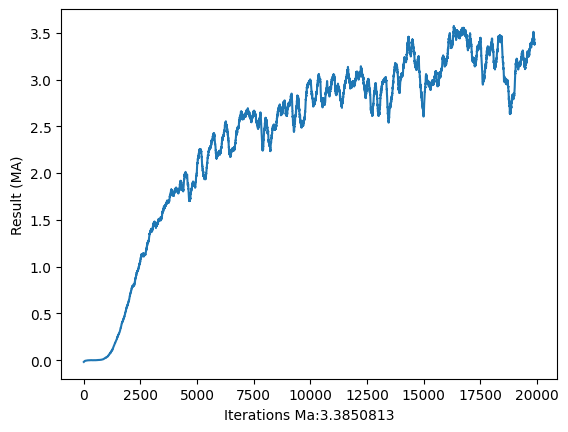

In [73]:
mine_net = Mine512(input_size=2*dim).cuda()
mine_net_optim = optim.Adam(mine_net.parameters(), lr=5e-4)
result, losses = train(sample_data, mine_net, mine_net_optim, iter_num=20000, log_freq=100)
result_cor_ma = ma(result)

plt.figure()
plt.plot(range(len(result_cor_ma)), result_cor_ma)
plt.xlabel("Iterations Ma:" + str(result_cor_ma[-1]))
plt.ylabel("Result (MA)")
plt.show()

  0%|          | 0/20000 [00:00<?, ?it/s]/tmp/ipykernel_795634/3230909598.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[i][1], dtype=torch.float32) for i in indices]
/tmp/ipykernel_795634/3230909598.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[m][1], dtype=torch.float32) for m in marginal_indices]
100%|██████████| 20000/20000 [01:58<00:00, 168.20it/s]


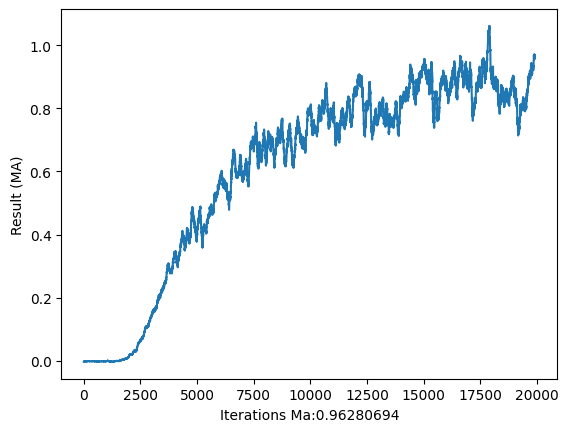

In [82]:
mine_net = Mine100(input_size=2*dim).cuda()
mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-3)
result, losses = train(sample_data, mine_net, mine_net_optim, iter_num=20000, log_freq=100, batch_size=100)
result_cor_ma = ma(result)

plt.figure()
plt.plot(range(len(result_cor_ma)), result_cor_ma)
plt.xlabel("Iterations Ma:" + str(result_cor_ma[-1]))
plt.ylabel("Result (MA)")
plt.show()

# Dim =7, relative value aligns with ground truth
Both model with hs = 512 and hs = 128 works well

In [44]:
test_hidden_size(0.9, dim)

  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_795634/3230909598.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[i][1], dtype=torch.float32) for i in indices]
/tmp/ipykernel_795634/3230909598.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[m][1], dtype=torch.float32) for m in marginal_indices]
100%|██████████| 500/500 [00:02<00:00, 194.81it/s]


(5.812559223875779, 0.8095346, 0.7884772)

In [50]:
test_hidden_size(0.7, dim)

  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_795634/3230909598.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[i][1], dtype=torch.float32) for i in indices]
/tmp/ipykernel_795634/3230909598.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[m][1], dtype=torch.float32) for m in marginal_indices]
100%|██████████| 500/500 [00:02<00:00, 193.13it/s]


(2.3567059364231793, 0.31495145, 0.29230413)

In [51]:
test_hidden_size(0.5, dim)

  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_795634/3230909598.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[i][1], dtype=torch.float32) for i in indices]
/tmp/ipykernel_795634/3230909598.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[m][1], dtype=torch.float32) for m in marginal_indices]
100%|██████████| 500/500 [00:02<00:00, 194.57it/s]


(1.0068872535812332, 0.1286859, 0.113823965)

In [52]:
test_hidden_size(0.3, dim)

  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_795634/3230909598.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[i][1], dtype=torch.float32) for i in indices]
/tmp/ipykernel_795634/3230909598.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[m][1], dtype=torch.float32) for m in marginal_indices]
100%|██████████| 500/500 [00:02<00:00, 193.54it/s]


(0.3300873781493445, 0.00023095217, 0.024847126)

In [53]:
test_hidden_size(-0.7, dim)

  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_795634/3230909598.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[i][1], dtype=torch.float32) for i in indices]
/tmp/ipykernel_795634/3230909598.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[m][1], dtype=torch.float32) for m in marginal_indices]
100%|██████████| 500/500 [00:02<00:00, 193.99it/s]


(2.3567059364231793, 0.30621192, 0.26894084)

In [54]:
test_hidden_size(-0.9, dim)

  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_795634/3230909598.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[i][1], dtype=torch.float32) for i in indices]
/tmp/ipykernel_795634/3230909598.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[m][1], dtype=torch.float32) for m in marginal_indices]
100%|██████████| 500/500 [00:02<00:00, 195.10it/s]


(5.812559223875779, 0.7872355, 0.7850165)

# DIM = 1000

In [88]:
def test_hidden_size(rou, dim):
    sample, mutual_info = high_dim_gauss(rou, dim, lens)
    sample = torch.tensor(sample, dtype=torch.float32)
    sample_data=[]
    for i in sample:
        data=[]
        data.append(i[:dim].to(torch.float32))
        data.append(i[dim:].to(torch.float32))
        sample_data.append(data)
        
    mine_net = Mine512(input_size=2*dim).cuda()
    mine_net_optim = optim.Adam(mine_net.parameters(), lr=5e-4)
    result, losses = train(sample_data, mine_net, mine_net_optim, iter_num=20000, log_freq=100)
    result_cor_ma1 = ma(result)
    
    mine_net = Mine100(input_size=2*dim).cuda()
    mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-3)
    result, losses = train(sample_data, mine_net, mine_net_optim, iter_num=20000, log_freq=100)
    result_cor_ma2 = ma(result)
    
    return mutual_info, result_cor_ma1, result_cor_ma2
    

In [84]:
dim = 1000
test_hidden_size(0.9, dim)

  0%|          | 0/20000 [00:00<?, ?it/s]/tmp/ipykernel_795634/3230909598.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[i][1], dtype=torch.float32) for i in indices]
/tmp/ipykernel_795634/3230909598.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[m][1], dtype=torch.float32) for m in marginal_indices]
100%|██████████| 20000/20000 [03:24<00:00, 97.96it/s]


(830.3656034108255, 2.6190538, 1.3178924)

In [86]:
dim = 1000
test_hidden_size(0.7, dim)

  0%|          | 0/20000 [00:00<?, ?it/s]/tmp/ipykernel_795634/3230909598.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[i][1], dtype=torch.float32) for i in indices]
/tmp/ipykernel_795634/3230909598.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[m][1], dtype=torch.float32) for m in marginal_indices]
100%|██████████| 20000/20000 [03:24<00:00, 97.96it/s]


(336.67227663188277, 3.3555875, 1.7438318)

In [85]:
dim = 1000
test_hidden_size(0.3, dim)

  0%|          | 0/20000 [00:00<?, ?it/s]/tmp/ipykernel_795634/3230909598.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[i][1], dtype=torch.float32) for i in indices]
/tmp/ipykernel_795634/3230909598.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[m][1], dtype=torch.float32) for m in marginal_indices]
100%|██████████| 20000/20000 [03:24<00:00, 97.58it/s]


(47.15533973562064, 3.094552, 1.6305437)

In [87]:
dim = 1000
test_hidden_size(-0.7, dim)

  0%|          | 0/20000 [00:00<?, ?it/s]/tmp/ipykernel_795634/3230909598.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[i][1], dtype=torch.float32) for i in indices]
/tmp/ipykernel_795634/3230909598.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[m][1], dtype=torch.float32) for m in marginal_indices]
100%|██████████| 20000/20000 [03:23<00:00, 98.41it/s] 


(336.67227663188277, 3.1473258, 1.6421396)

In [89]:
mutual_info9, result_cor_ma512_9, result_cor_ma128_9 = test_hidden_size(0.9, dim)
mutual_info7, result_cor_ma512_7, result_cor_ma128_7 = test_hidden_size(0.7, dim)
mutual_info3, result_cor_ma512_3, result_cor_ma128_3 = test_hidden_size(0.3, dim)

  0%|          | 0/20000 [00:00<?, ?it/s]/tmp/ipykernel_795634/3230909598.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[i][1], dtype=torch.float32) for i in indices]
/tmp/ipykernel_795634/3230909598.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vectors = [torch.tensor(data[m][1], dtype=torch.float32) for m in marginal_indices]
100%|██████████| 20000/20000 [03:23<00:00, 98.34it/s]


In [93]:
len(result_cor_ma512_9)

19900

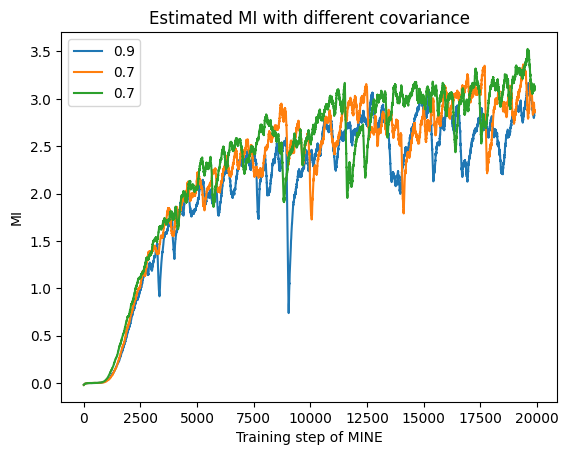

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import math

plt.plot(range(len(result_cor_ma512_9)), result_cor_ma512_9, label='0.9')
plt.plot(range(len(result_cor_ma512_9)), result_cor_ma512_7, label='0.7')
plt.plot(range(len(result_cor_ma512_9)), result_cor_ma512_3, label='0.7')

plt.xlabel("Training step of MINE")
plt.ylabel("MI")
plt.title("Estimated MI with different covariance")
plt.legend()
plt.show()

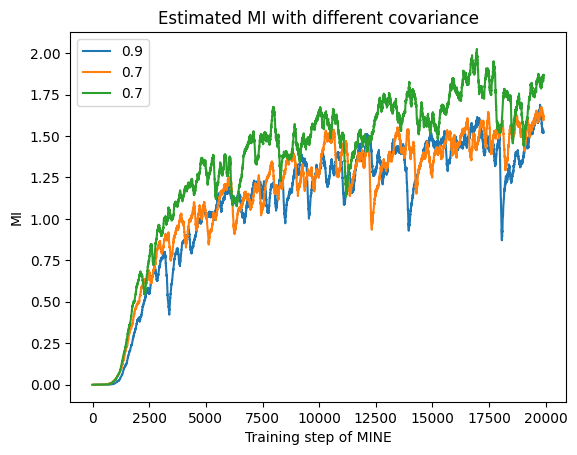

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import math

plt.plot(range(len(result_cor_ma512_9)), result_cor_ma128_9, label='0.9')
plt.plot(range(len(result_cor_ma512_9)), result_cor_ma128_7, label='0.7')
plt.plot(range(len(result_cor_ma512_9)), result_cor_ma128_3, label='0.7')

plt.xlabel("Training step of MINE")
plt.ylabel("MI")
plt.title("Estimated MI with different covariance")
plt.legend()
plt.show()